# Problem Statement
 Develop a robust image classification system capable of distinguishing between different types of vegetables—specifically onions, potatoes, and tomatoes—as well as identifying images that do not belong to any of these categories (noise). The dataset consists of labeled images organized into training and testing sets, with four classes: onions, potatoes, tomatoes, and market scenes (noise).

# Objective
The goal is to build a multiclass image classifier that accurately categorizes input images into one of the four predefined classes using convolutional neural networks (CNNs). The system should leverage modern deep learning techniques, implement appropriate callbacks, address potential overfitting, and explore transfer learning methods to enhance model performance.

In [1]:
# Standard library imports
import os
import glob
import zipfile
import pickle
import random

# Scientific computing and data handling
import numpy as np
import pandas as pd

# Deep learning and neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers,Sequential,applications

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning metrics
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

# mlflow logging
import mlflow
import mlflow.tensorflow

# File downloading
import gdown

# Image processing
import cv2

In [2]:
# Download the file with the correct direct link
gdown.download("https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT", "output.zip", quiet=False)

# Unzip the file
with zipfile.ZipFile("output.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=a30ae5d6-cdd9-4fda-933c-52801f68d0c5
To: d:\Github\image_classification_cv\notebook\output.zip
100%|██████████| 275M/275M [00:46<00:00, 5.90MB/s] 


# EDA

Creating Image and Count Dictionary

In [3]:
# Define dataset directories
dataset_dirs = {
    "train": r"data/ninjacart_data/train",
    "test": r"data/ninjacart_data/test"
}

# Store class directories separately for future use in dictionary format
class_dir = {"train": [], "test": []}

# Dictionaries to store image counts and random images
image_dict = {"train": {}, "test": {}}
count_dict = {"train": {}, "test": {}}

# Set random seed for reproducibility
random.seed(43)

# Process both train and test datasets
for dataset in ["train", "test"]:
    path = dataset_dirs[dataset]  # Get dataset path
    class_dir[dataset] = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]  # Get class names
    
    for cls in class_dir[dataset]:
        # Get all image paths in the class folder
        file_paths = glob.glob(os.path.join(path, cls, '*'))
        
        # Store the number of images per class
        count_dict[dataset][cls] = len(file_paths)
        
        # Select a random image from the class and store it
        if file_paths:  # Ensure there are images before choosing
            image_path = random.choice(file_paths)
            image_dict[dataset][cls] = tf.keras.utils.load_img(image_path)

print("class_dir :",class_dir)
print("image_dict :",image_dict)
print("count_dict :",count_dict)

class_dir : {'train': ['indian market', 'onion', 'potato', 'tomato'], 'test': ['indian market', 'onion', 'potato', 'tomato']}
image_dict : {'train': {'indian market': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x2704DAA9BD0>, 'onion': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x2704DDC2500>, 'potato': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=183x275 at 0x2704DDC2560>, 'tomato': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x500 at 0x2704DDC25F0>}, 'test': {'indian market': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=262x192 at 0x2704DDC2680>, 'onion': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x320 at 0x2704DDC2710>, 'potato': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=266x189 at 0x2704DDC2740>, 'tomato': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x400 at 0x2704DDC27A0>}}
count_dict : {'train': {'indian market': 599, 'onion': 849, 'potato': 898, 'tomato': 789}, 'tes

Plotting class distributions

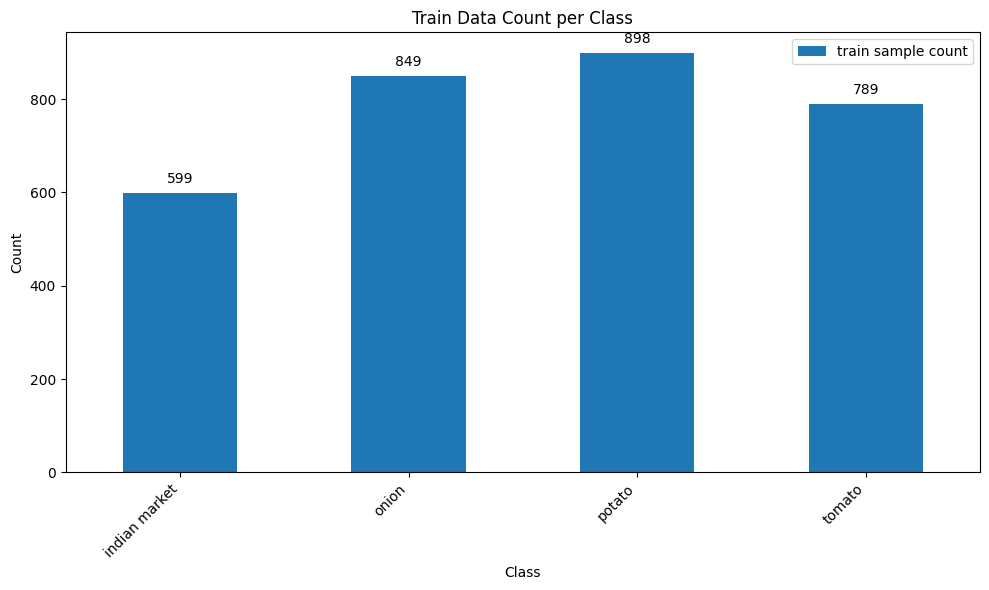

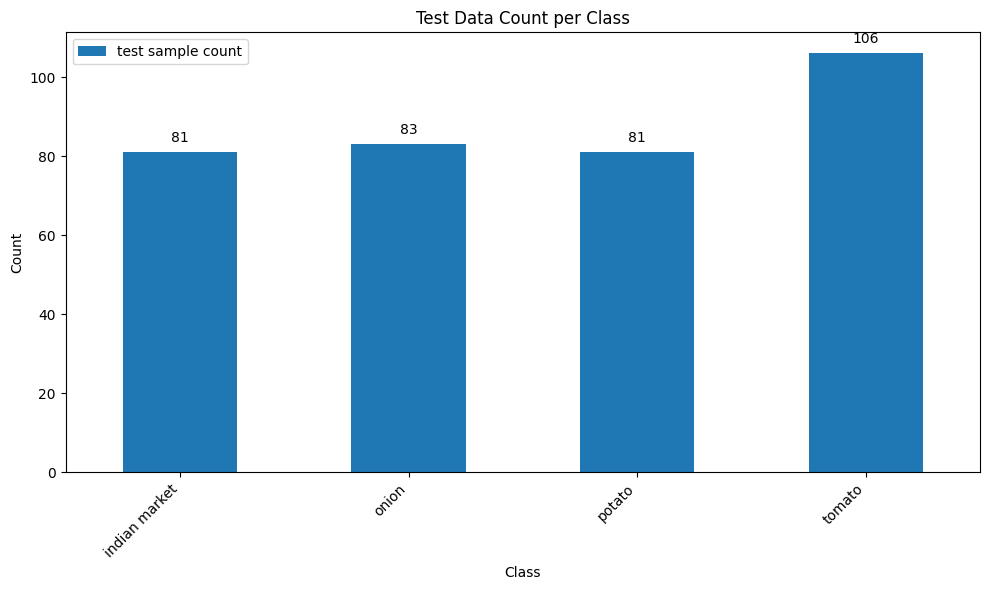

In [4]:
# Function to plot data distribution
def plot_data_distribution(dataset_type, count_dict):
    # Convert count_dict to DataFrame
    df_count = pd.DataFrame({
        "class": list(count_dict.keys()),     # Get class names
        "count": list(count_dict.values()),   # Get image counts
    })

    # print(f"Count of {dataset_type} samples per class:\n", df_count, "\n")

    # Create bar plot
    ax = df_count.plot.bar(x='class', y='count', title=f"{dataset_type.capitalize()} Data Count per Class", 
                           label=f'{dataset_type} sample count', figsize=(10, 6))

    # Annotate bars with their counts
    for bar in ax.patches:
        ax.annotate(f'{bar.get_height()}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Set labels and title
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f"{dataset_type.capitalize()} Data Count per Class")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot Training Data Distribution
plot_data_distribution("train", count_dict["train"])

# Plot Test Data Distribution
plot_data_distribution("test", count_dict["test"])

We have data imbalance in both train and test datasets which will result in biased prediction towards some classes

Visualizing Random Images with Dimensions from each class

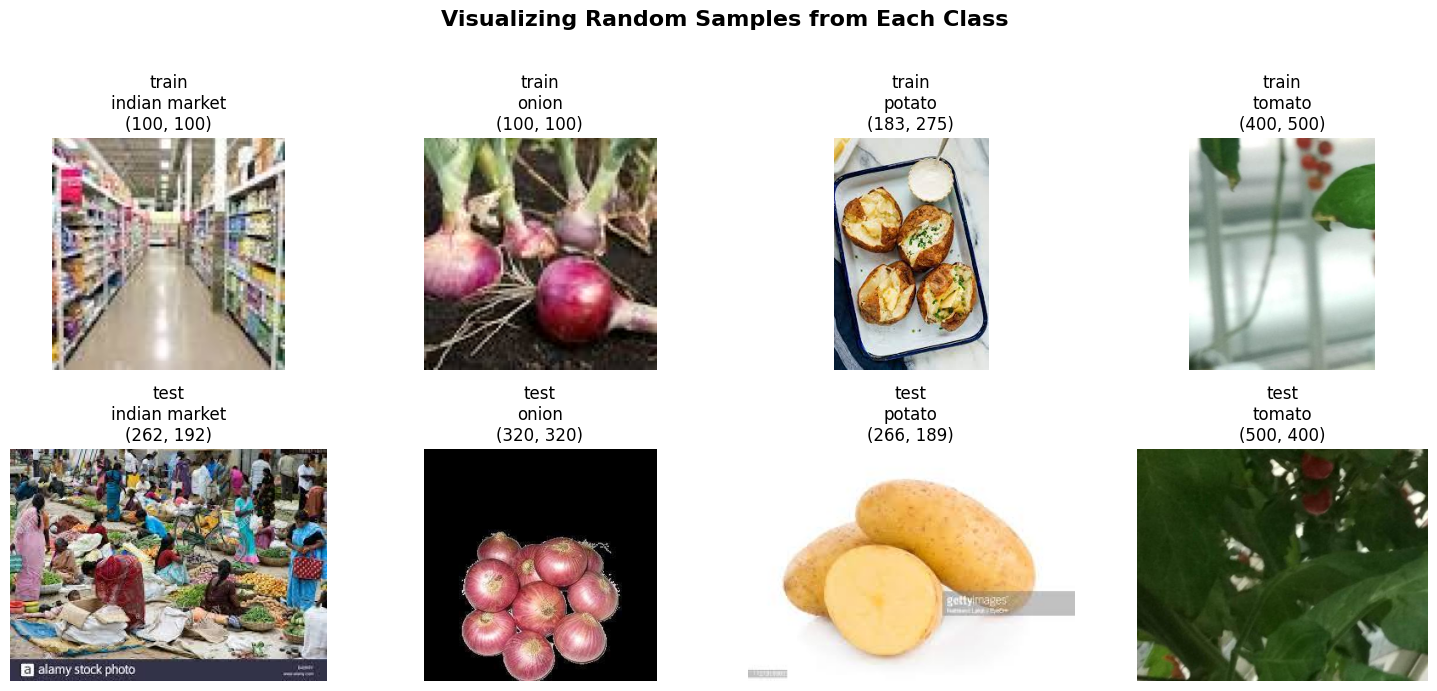

In [5]:
# Define number of classes (assuming same for train & test)
num_classes = len(image_dict["train"])

# Create a figure with 2 rows (train & test), num_classes columns
fig, axes = plt.subplots(2, num_classes, figsize=(15, 7))

# Set overall title
fig.suptitle("Visualizing Random Samples from Each Class", fontsize=16, fontweight="bold")

# Iterate over train and test datasets
for row, dataset in enumerate(["train", "test"]):  # Row 0: Train, Row 1: Test
    for col, cls in enumerate(image_dict[dataset]):  # Iterate through class names
        img = image_dict[dataset][cls]  # Get the selected image
        
        # Plot image
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f'{dataset}\n{cls}\n{img.size}', fontsize=12)
        ax.axis("off")
        
    # Add dataset title on the leftmost side of each row
    axes[row, 0].set_ylabel(dataset.upper(), fontsize=14, fontweight="bold", rotation=90, labelpad=20)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Original image sizes vary widely across the images. I will be resizing it to 256*256 for model compatibility.
Market images consists of multiple objects which will probably lead to misclassification as compared to single objects for other classes

# Data Preprocessing
Train validation split and Resizing


Loading Data...

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Found 351 files belonging to 4 classes.
Dataset Image Counts


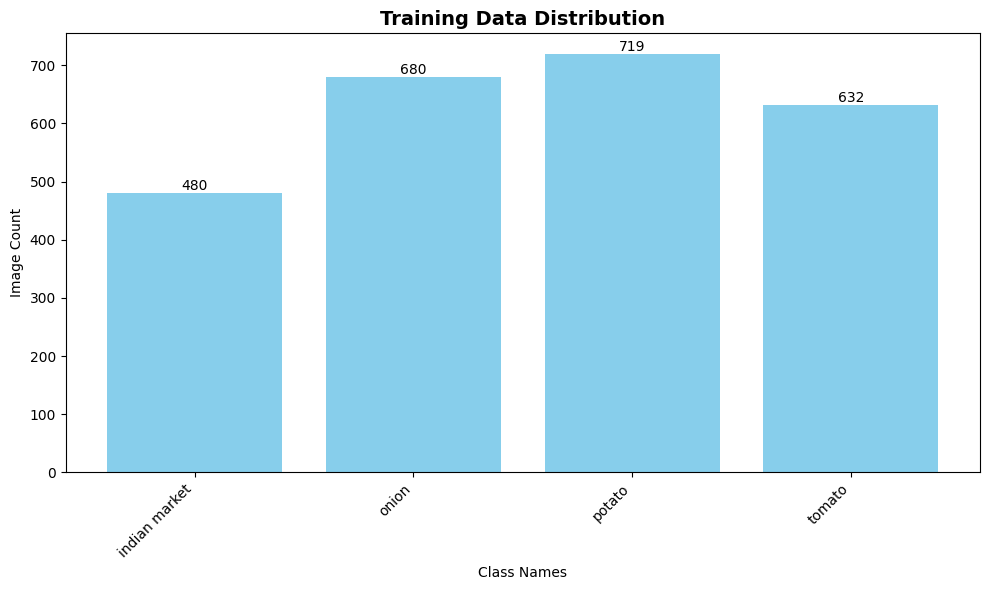

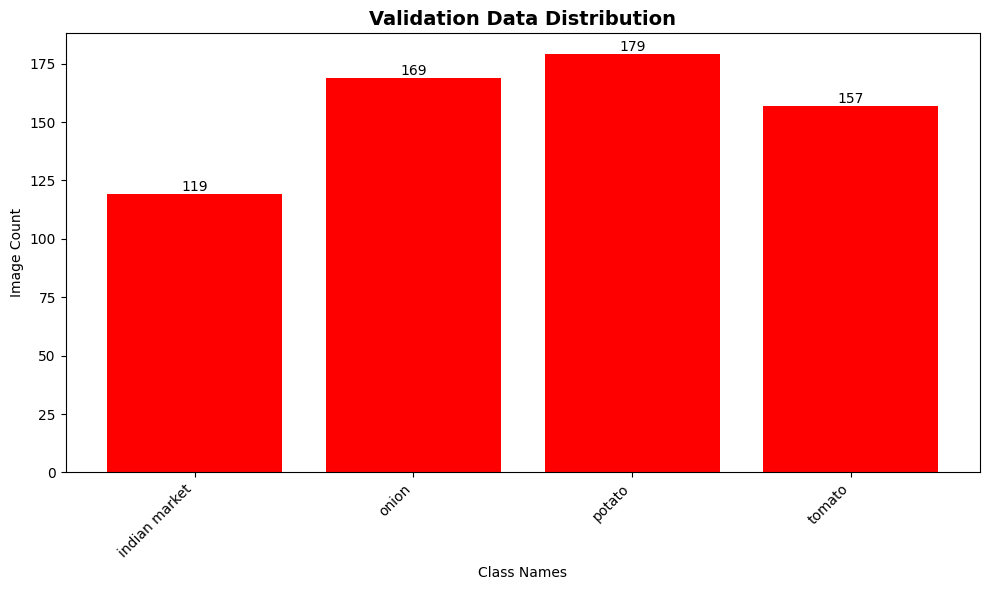

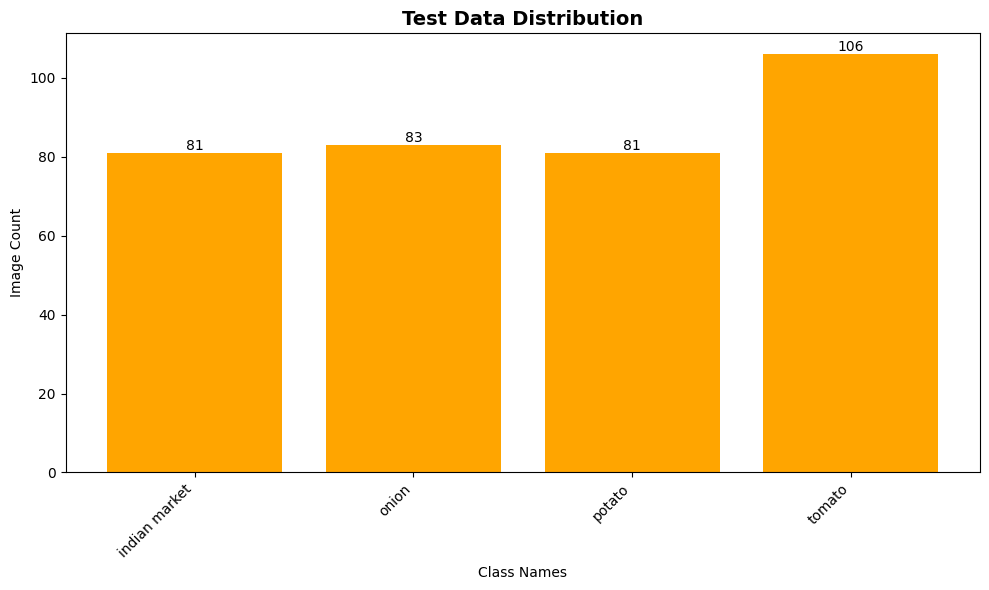

In [6]:
def load_data(base_dir="data/ninjacart_data", validation_split=0.2):
    # Ensure data folders exist
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...\n')

    # Function to count images in each class
    def count_images(dataset_type):
        dataset_path = f"{base_dir}/{dataset_type}"
        class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        class_counts = {cls: len(glob.glob(os.path.join(dataset_path, cls, '*'))) for cls in class_dirs}
        return class_counts

    # Count images in train and test sets before splitting
    train_counts = count_images("train")
    test_counts = count_images("test")  # Added explicitly for clarity

    # Load the train dataset and apply validation split
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/train",
        shuffle=True,
        label_mode='categorical',
        batch_size=32,
        validation_split=validation_split,
        subset='training',
        image_size = (256,256),
        seed=123
    )

    # Validation data (from the same directory, using validation_split)
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/train",
        shuffle=True,
        label_mode='categorical',
        batch_size=32,
        validation_split=validation_split,
        subset='validation',
        image_size = (256,256),
        seed=123
    )

    # Load the test data (no split applied)
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/test",
        shuffle=False,
        label_mode='categorical',
        batch_size=32,
        image_size = (256,256)
    )

    # Get class names
    class_names = train_data.class_names

    # Compute validation image counts using the split ratio
    val_counts = {cls: int(train_counts[cls] * validation_split) for cls in class_names}

    # Adjust training counts after validation split
    train_counts = {cls: train_counts[cls] - val_counts[cls] for cls in class_names}

    # Print dataset statistics
    print("Dataset Image Counts")

        # Convert counts into DataFrames
    df_train = pd.DataFrame(list(train_counts.items()), columns=["Class", "Count"])
    df_val = pd.DataFrame(list(val_counts.items()), columns=["Class", "Count"])
    df_test = pd.DataFrame(list(test_counts.items()), columns=["Class", "Count"])

    # Function to plot bar charts
    def plot_counts(df, title, color):
        plt.figure(figsize=(10, 6))
        bars = plt.bar(df["Class"], df["Count"], color=color)
        plt.xlabel("Class Names")
        plt.ylabel("Image Count")
        plt.title(title, fontsize=14, fontweight="bold")
        plt.xticks(rotation=45, ha="right")

        # Annotate bar heights
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height()}", 
                    ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()

    # Plot training, validation, and test image distributions
    plot_counts(df_train, "Training Data Distribution", "skyblue")
    plot_counts(df_val, "Validation Data Distribution", "red")
    plot_counts(df_test, "Test Data Distribution", "orange")

    return train_data, val_data, test_data, class_names

# Call the function to load data
train_data, val_data, test_data, class_names = load_data()

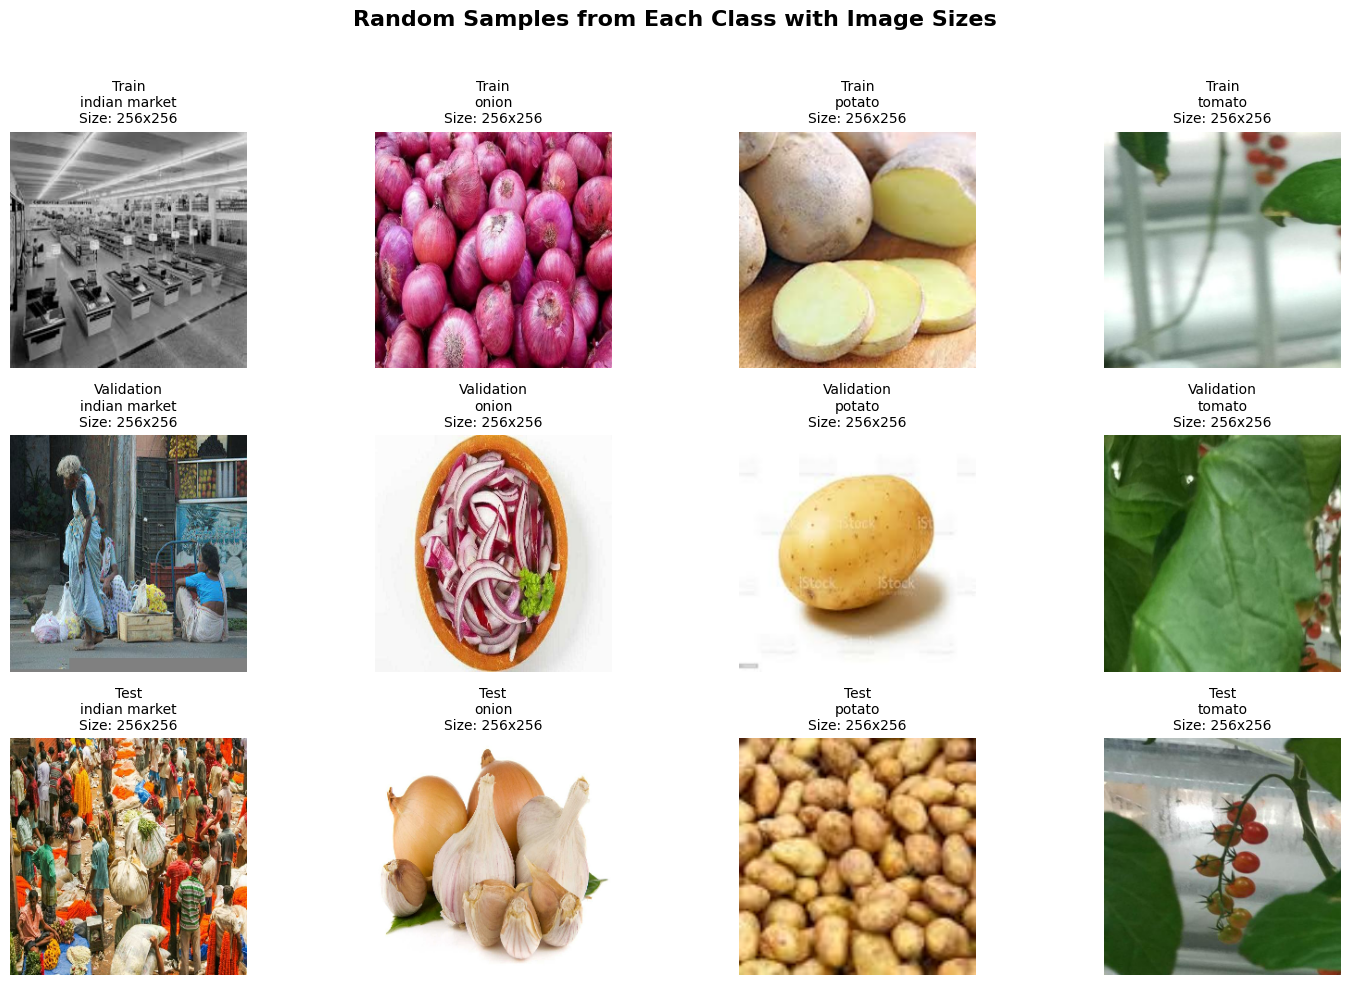

In [7]:
# Function to extract one random image per class from a dataset
def get_random_images(dataset, class_names):
    class_images = {}  # Dictionary to store random images
    for images, labels in dataset:  # Iterate over batches
        for img, lbl in zip(images.numpy(), labels.numpy()):
            class_idx = np.argmax(lbl)  # Get class index
            class_name = class_names[class_idx]  # Map index to class name
            if class_name not in class_images:  # Store only one image per class
                class_images[class_name] = img
            if len(class_images) == len(class_names):  # Stop when all classes are covered
                return class_images
    return class_images

# Fetch one random image per class from each dataset
train_images = get_random_images(train_data, class_names)
val_images = get_random_images(val_data, class_names)
test_images = get_random_images(test_data, class_names)

# Define number of classes
num_classes = len(class_names)

# Create a figure with 3 rows (Train, Validation, Test) and num_classes columns
fig, axes = plt.subplots(3, num_classes, figsize=(15, 10))

# Set overall title
fig.suptitle("Random Samples from Each Class with Image Sizes", fontsize=16, fontweight="bold")

# Iterate over train, val, and test datasets
for row, (dataset_name, dataset_images) in enumerate(zip(["Train", "Validation", "Test"], [train_images, val_images, test_images])):
    for col, cls in enumerate(class_names):  # Iterate through class names
        img = dataset_images.get(cls)  # Get the selected image
        if img is not None:
            ax = axes[row, col]
            ax.imshow(img.astype("uint8"))  # Convert image to displayable format

            # Extract image size (height, width, channels)
            img_size = img.shape  # (height, width, channels)
            size_text = f"{img_size[0]}x{img_size[1]}"  # Format size

            # Set title with dataset name, class, and image size
            ax.set_title(f"{dataset_name}\n{cls}\nSize: {size_text}", fontsize=10)
            ax.axis("off")

    # Add dataset title on the leftmost side of each row
    axes[row, 0].set_ylabel(dataset_name.upper(), fontsize=14, fontweight="bold", rotation=90, labelpad=20)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Dataset splitted into train, validation and test split(Train: 80% (2508 images), Validation: 20% (627 images), Test: 351 images). Validation set used to tune hyperparameters and prevent overfitting. <br> All images resized to 256x256 to ensure uniformity.

Rescaling

In [8]:
def preprocess(train_data, val_data, test_data, target_height=256, target_width=256):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            #layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

Pixel values normalized to [0, 1] to stabilize training.

CNN Model with single Conv2D block

In [9]:
def baseline(height=256, width=256, num_classes=4):
    hidden_size = 256

    model = keras.Sequential(
        name="simple_cnn1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')  # Final output layer
        ]
    )
    return model

# Create and summarize the model
model = baseline()
model.summary()

c:\Users\Admin\.conda\envs\cvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "simple_cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,110,596 (256.01 MB)

 Trainable params: 67,110,596 (256.01 MB)

 Non-trainable params: 0 (0.00 B)

Model Compilation and Training

In [10]:
def compile_train(model, train_ds, val_ds, epochs=10, log_dir = f"logs/{model.name}",ckpt_path=f"checkpoints/{model.name}.weights.h5"):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Define Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            save_weights_only=True,  # Saves only model weights
            monitor='val_accuracy', 
            mode='max', 
            save_best_only=True  # Saves only the best model based on validation accuracy
        ),
        keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)  # TensorBoard Logging
    ]

    # Train the model
    model_fit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,  # Now customizable
        callbacks=callbacks
    )

    return model_fit

In [11]:
model_fit = compile_train(model, train_ds, val_ds, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 435s 6s/step - accuracy: 0.4526 - loss: 24.3333 - precision: 0.4588 - recall: 0.4306 - val_accuracy: 0.7464 - val_loss: 0.8380 - val_precision: 0.7661 - val_recall: 0.7209
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.7776 - loss: 0.7235 - precision: 0.7965 - recall: 0.7621 - val_accuracy: 0.7735 - val_loss: 0.8308 - val_precision: 0.7901 - val_recall: 0.7624
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.8930 - loss: 0.3158 - precision: 0.9081 - recall: 0.8833 - val_accuracy: 0.7687 - val_loss: 0.6699 - val_precision: 0.7855 - val_recall: 0.7592
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.9272 - loss: 0.2407 - precision: 0.9342 - recall: 0.9194 - val_accuracy: 0.8246 - val_loss: 0.5983 - val_precision: 0.8309 - val_recall: 0.8150
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 55962s 717s/step - accuracy: 0.9657 - loss: 0.1055 - precision: 0.9682 - recall: 0.9631 - val_accuracy: 0.7815 - val_loss: 0.

Plot Training and Validation Accuracy

In [12]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

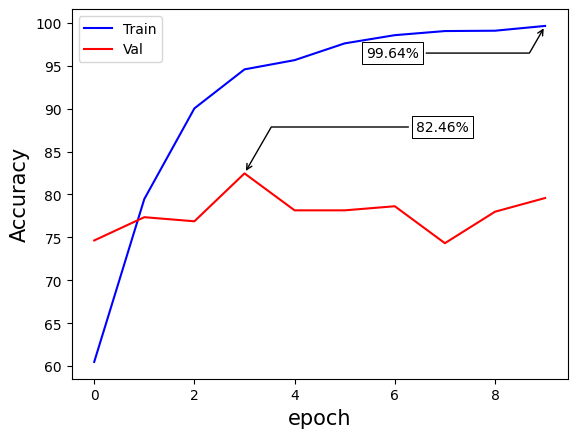

In [13]:
plot_accuracy(model_fit)

In [14]:
%load_ext tensorboard

In [15]:
%tensorboard --logdir logs/simple_cnn1/

Model Evaluation, Mlflow Logging and Printing Metrics

In [16]:
def evaluate_model(model, train_ds, val_ds, test_ds, class_names, run_name, ckpt_path):
    mlflow.set_experiment("Vegetable_image_classification")
    
    with mlflow.start_run(run_name=run_name):
        model.load_weights(ckpt_path)
        mlflow.tensorflow.log_model(model, "model")
        mlflow.log_param("checkpoint_path", ckpt_path)
        
        def get_metrics(ds, dataset_name):
            y_true, y_pred = [], []
            for x, y in ds:
                y_true.extend(tf.argmax(y, axis=1).numpy().tolist())
                preds = model(x, training=False)
                y_pred.extend(tf.argmax(preds, axis=1).numpy().tolist())

            acc = accuracy_score(y_true, y_pred) * 100
            prec = precision_score(y_true, y_pred, average="macro") * 100
            rec = recall_score(y_true, y_pred, average="macro") * 100

            mlflow.log_metric(f"{dataset_name}_accuracy", acc)
            mlflow.log_metric(f"{dataset_name}_precision", prec)
            mlflow.log_metric(f"{dataset_name}_recall", rec)
            
            print(f"\n{dataset_name} Metrics:")
            print(f" Accuracy: {acc:.2f}%")
            print(f" Precision: {prec:.2f}%")
            print(f" Recall: {rec:.2f}%")
            
            return y_true, y_pred
        
        train_y_true, train_y_pred = get_metrics(train_ds, "train")
        val_y_true, val_y_pred = get_metrics(val_ds, "val")
        test_y_true, test_y_pred = get_metrics(test_ds, "test")

        def plot_confusion_matrix(y_true, y_pred, dataset_name):
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title(f'Confusion Matrix - {dataset_name}')
            plt.savefig(f"conf_matrix_{dataset_name}.png")
            mlflow.log_artifact(f"conf_matrix_{dataset_name}.png")
            plt.show()
            plt.close()
        
        plot_confusion_matrix(train_y_true, train_y_pred, "train")
        plot_confusion_matrix(val_y_true, val_y_pred, "val")
        plot_confusion_matrix(test_y_true, test_y_pred, "test")

        def log_classification_report(y_true, y_pred, dataset_name):
            report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
            mlflow.log_dict(report, f"classification_report_{dataset_name}.json")
            print(f"\nClassification Report - {dataset_name}")
            print(classification_report(y_true, y_pred, target_names=class_names))
        
        log_classification_report(train_y_true, train_y_pred, "train")
        log_classification_report(val_y_true, val_y_pred, "val")
        log_classification_report(test_y_true, test_y_pred, "test")
        
        print("\nClass-wise Accuracy:")
        for dataset_name, y_true, y_pred in zip(["train", "val", "test"], [train_y_true, val_y_true, test_y_true], [train_y_pred, val_y_pred, test_y_pred]):
            print(f"\n{dataset_name.capitalize()} Class-wise Accuracy:")
            for i, class_name in enumerate(class_names):
                total_count = y_true.count(i)
                correct_count = sum(1 for true, pred in zip(y_true, y_pred) if true == pred and true == i)
                class_acc = (correct_count / total_count) * 100 if total_count > 0 else 0
                mlflow.log_metric(f"{dataset_name}_class_accuracy_{class_name}", class_acc)
                print(f" {class_name}: {class_acc:.2f}% ({correct_count}/{total_count})")
        
        print("\nRandom Test Predictions:")
        samples_per_class = 2
        fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(10, 2 * len(class_names)))

        test_images = list(test_ds.unbatch().as_numpy_iterator())
        grouped_by_class = {i: [] for i in range(len(class_names))}

        for img, label in test_images:
            class_idx = np.argmax(label)
            grouped_by_class[class_idx].append((img, class_idx))

        for row, cls_idx in enumerate(grouped_by_class):
            selected_samples = random.sample(grouped_by_class[cls_idx], min(samples_per_class, len(grouped_by_class[cls_idx])))

            for col, (img, true_label) in enumerate(selected_samples):
                img_input = np.expand_dims(img, axis=0)
                pred = model(img_input, training=False)
                predicted_label = np.argmax(pred)

                ax = axes[row, col]
                
                # **Fix: Rescale image to original format (0-255) and convert to uint8**
                img = (img * 255).astype("uint8")
                
                ax.imshow(img)
                ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
                ax.axis("off")

        plt.tight_layout()
        plt.savefig("random_test_predictions.png")
        mlflow.log_artifact("random_test_predictions.png")
        plt.show()

        mlflow.end_run()

2025/06/01 16:28:40 INFO mlflow.tracking.fluent: Experiment with name 'Vegetable_image_classification' does not exist. Creating a new experiment.
2025/06/01 16:28:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/06/01 16:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



train Metrics:
 Accuracy: 98.25%
 Precision: 98.44%
 Recall: 98.33%

val Metrics:
 Accuracy: 82.46%
 Precision: 82.48%
 Recall: 82.43%

test Metrics:
 Accuracy: 79.49%
 Precision: 79.54%
 Recall: 78.20%


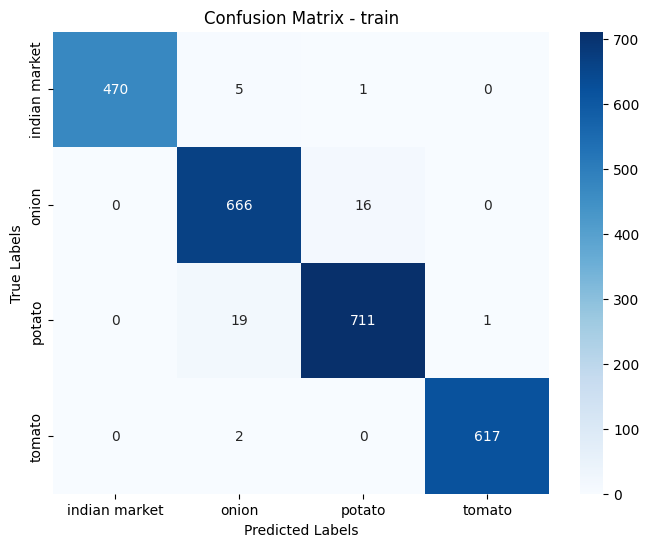

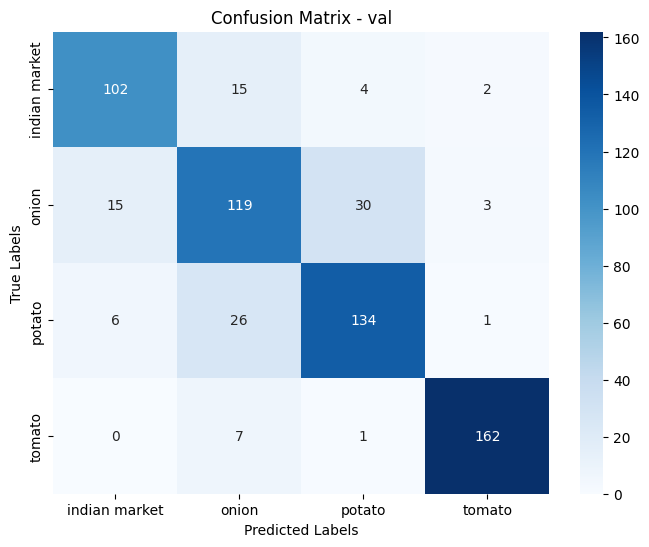

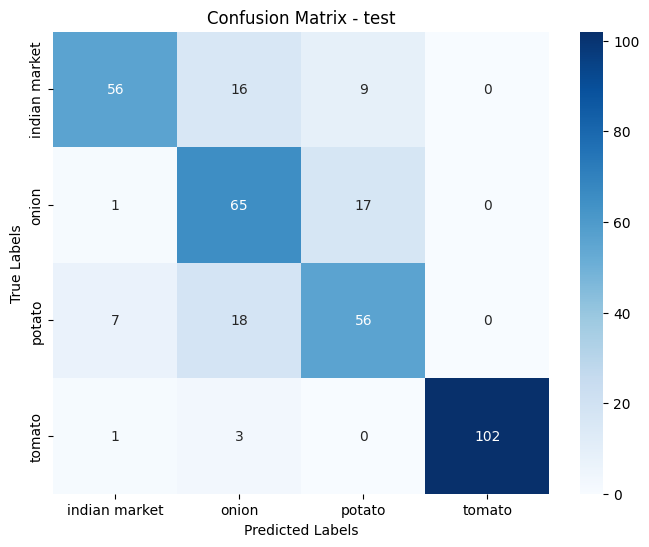


Classification Report - train
               precision    recall  f1-score   support

indian market       1.00      0.99      0.99       476
        onion       0.96      0.98      0.97       682
       potato       0.98      0.97      0.97       731
       tomato       1.00      1.00      1.00       619

     accuracy                           0.98      2508
    macro avg       0.98      0.98      0.98      2508
 weighted avg       0.98      0.98      0.98      2508


Classification Report - val
               precision    recall  f1-score   support

indian market       0.83      0.83      0.83       123
        onion       0.71      0.71      0.71       167
       potato       0.79      0.80      0.80       167
       tomato       0.96      0.95      0.96       170

     accuracy                           0.82       627
    macro avg       0.82      0.82      0.82       627
 weighted avg       0.83      0.82      0.82       627


Classification Report - test
               precision

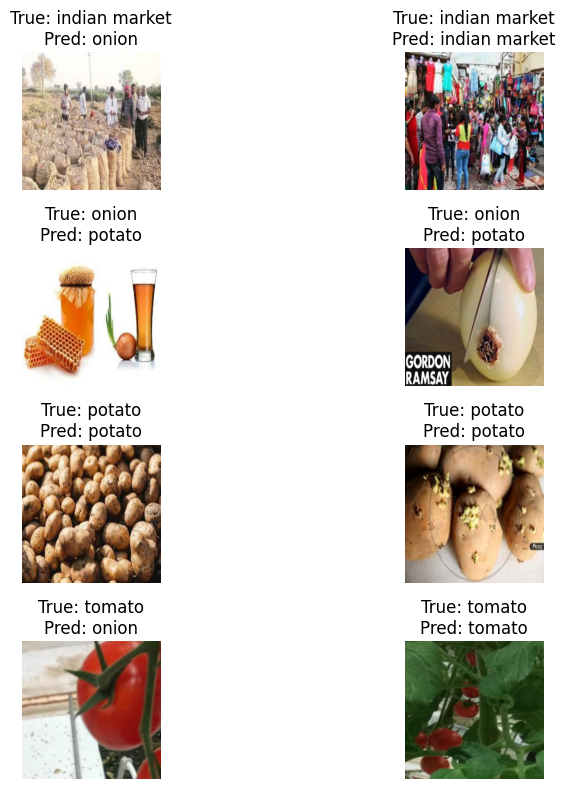

In [17]:

evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=f"{model.name}",ckpt_path= f"checkpoints/{model.name}.weights.h5")

In [20]:
model.save("saved_models/simple_cnn1_model.keras")

CNN model using 5 conv layers

In [21]:
def complex_cnn(height=256, width=256):
    num_classes = 4

    model = keras.Sequential(
        name="complex_cnn",
        layers=[
            # Block 1
            layers.Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(height, width, 3),
                          kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Block 2
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                          kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Block 3
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                          kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Block 4
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                          kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Block 5
            layers.Conv2D(filters=512, kernel_size=3, padding="same",
                          kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # **Global Average Pooling Instead of Flatten**
            layers.GlobalAveragePooling2D(),

            # Fully Connected Layers
            layers.Dense(units=512, kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.3),  # Keeping only this dropout

            # Fully Connected Layers
            layers.Dense(units=256, kernel_regularizer=regularizers.l2(5e-4)),
            layers.Activation("relu"),
            layers.BatchNormalization(),

            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [22]:
model = complex_cnn()
model.summary()

c:\Users\Admin\.conda\envs\cvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "complex_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,65

 Total params: 1,970,628 (7.52 MB)

 Trainable params: 1,967,108 (7.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

Model Compilation and Training including all Callback Features

In [23]:
def compile_train(model, train_ds, val_ds, epochs=10, log_dir= f"logs/{model.name}", ckpt_path = f"checkpoints/{model.name}.weights.h5"):
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),  # Default Adam optimizer
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Define Callbacks
    callbacks = [
        # Reduce learning rate if validation loss stops improving
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=1e-5
        ),
        # Save only the best model based on validation accuracy
        keras.callbacks.ModelCheckpoint(
            ckpt_path,
            save_weights_only=True,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True
        ),
        # Stop training early if validation loss does not improve
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            min_delta=0.1,
            mode="min",
            restore_best_weights=True  # Restore the best model
        ),
        # TensorBoard logging
        keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]

    # Train the model
    model_fit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    return model_fit

In [24]:

model_fit = compile_train(model, train_ds, val_ds, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 567s 7s/step - accuracy: 0.6840 - loss: 1.6980 - precision_1: 0.7174 - recall_1: 0.6406 - val_accuracy: 0.3700 - val_loss: 2.4087 - val_precision_1: 0.4130 - val_recall_1: 0.3142 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 543s 7s/step - accuracy: 0.7977 - loss: 1.2811 - precision_1: 0.8337 - recall_1: 0.7742 - val_accuracy: 0.2679 - val_loss: 2.4373 - val_precision_1: 0.2688 - val_recall_1: 0.2456 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 453s 6s/step - accuracy: 0.8098 - loss: 1.2363 - precision_1: 0.8287 - recall_1: 0.7844 - val_accuracy: 0.5120 - val_loss: 2.5461 - val_precision_1: 0.5195 - val_recall_1: 0.5104 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 416s 5s/step - accuracy: 0.8308 - loss: 1.1792 - precision_1: 0.8480 - recall_1: 0.8056 - val_accuracy: 0.5375 - val_loss: 2.1536 - val_precision_1: 0.5493 - val_recall_1: 0.5327 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━

Plot accuracy for training and validation wrt epoch

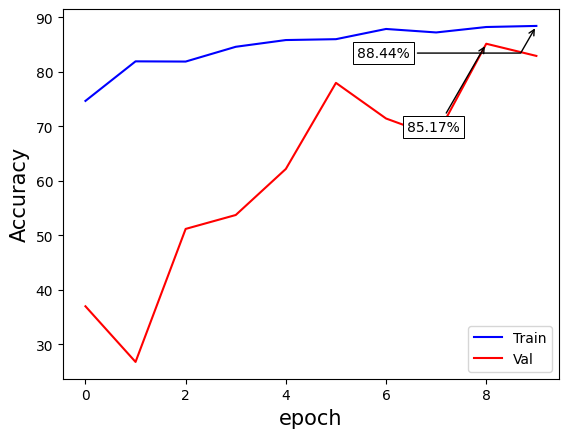

In [25]:
plot_accuracy(model_fit)

In [26]:
%reload_ext tensorboard

2025/06/01 22:21:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/06/01 22:22:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



train Metrics:
 Accuracy: 85.45%
 Precision: 87.60%
 Recall: 84.76%

val Metrics:
 Accuracy: 85.17%
 Precision: 86.37%
 Recall: 84.26%

test Metrics:
 Accuracy: 81.48%
 Precision: 84.96%
 Recall: 80.22%


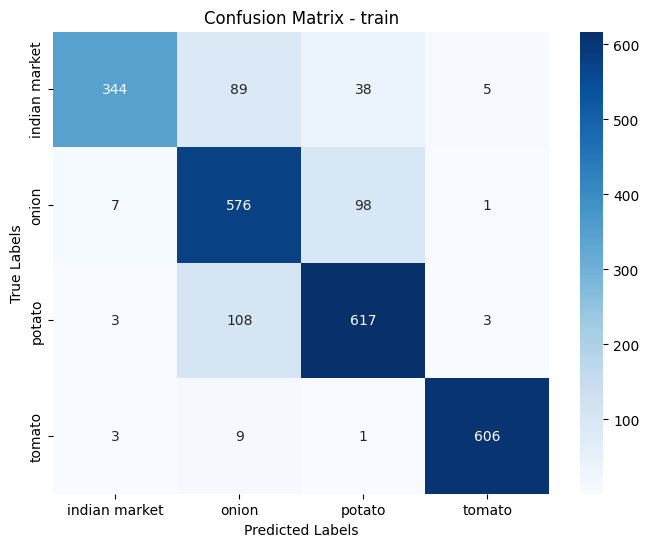

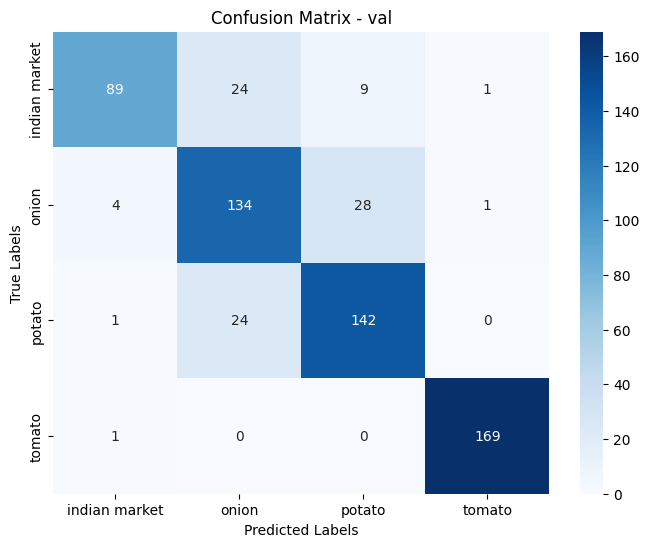

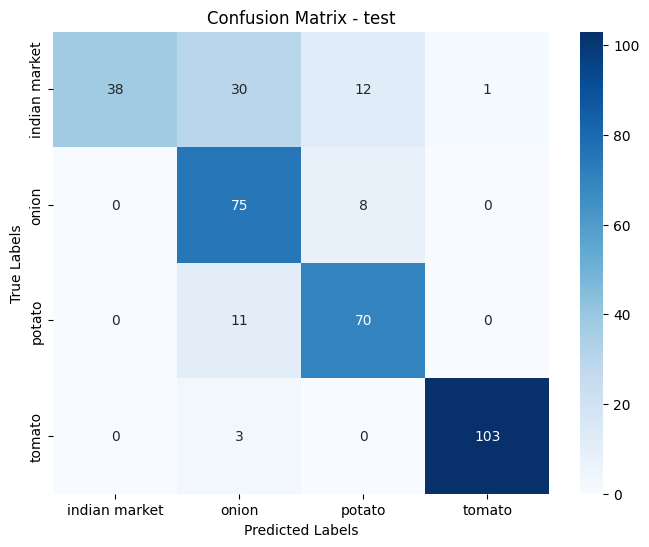


Classification Report - train
               precision    recall  f1-score   support

indian market       0.96      0.72      0.83       476
        onion       0.74      0.84      0.79       682
       potato       0.82      0.84      0.83       731
       tomato       0.99      0.98      0.98       619

     accuracy                           0.85      2508
    macro avg       0.88      0.85      0.86      2508
 weighted avg       0.86      0.85      0.86      2508


Classification Report - val
               precision    recall  f1-score   support

indian market       0.94      0.72      0.82       123
        onion       0.74      0.80      0.77       167
       potato       0.79      0.85      0.82       167
       tomato       0.99      0.99      0.99       170

     accuracy                           0.85       627
    macro avg       0.86      0.84      0.85       627
 weighted avg       0.86      0.85      0.85       627


Classification Report - test
               precision

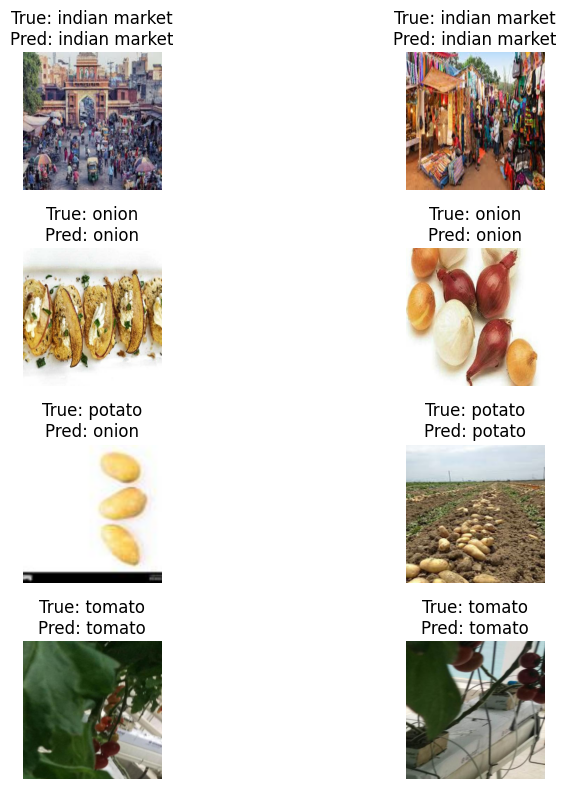

In [27]:
evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=f"{model.name}",ckpt_path= f"checkpoints/{model.name}.weights.h5")

In [28]:

model.save("saved_models/complex_cnn_model.keras")

## PRE TRAINED MODELS
VGG16

In [29]:
def pretrained_vgg16(height=256, width=256, num_classes=4, trainable_layers=0, ckpt_path=None):
    base_model = applications.VGG16(weights="imagenet", include_top=False, input_shape=(height, width, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # If fine-tuning, unfreeze last `trainable_layers`
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation="softmax")
    ], name="pretrained_vgg16")

    # Load weights only if a valid checkpoint is provided
    if ckpt_path and os.path.exists(ckpt_path):
        print(f"Loading weights from {ckpt_path}")
        model.load_weights(ckpt_path)

    return model

In [30]:
ckpt_path = "checkpoints/1_pretrained_vgg16_trainable0.weights.h5"
log_dir = "logs/1_pretrained_vgg16_trainable0"

# Load pretrained VGG16 model
model = pretrained_vgg16(height=256, width=256, num_classes=4, trainable_layers=0,ckpt_path=ckpt_path)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 73s 1us/step


In [31]:
model.summary()

Model: "pretrained_vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [ ]:
model_fit = compile_train(model, train_ds, val_ds, log_dir=log_dir,epochs=10,ckpt_path=ckpt_path)

Epoch 1/100
50/79 ━━━━━━━━━━━━━━━━━━━━ 7:00 14s/step - accuracy: 0.7016 - loss: 1.2197 - precision_2: 0.7280 - recall_2: 0.6620

In [ ]:
# Function to annotate max accuracy and min loss
def annot_max_min(x, y, metric, ax=None):
    if not ax:
        ax = plt.gca()
    
    idx = np.argmax(y) if "accuracy" in metric else np.argmin(y)
    text = f"{'Max' if 'accuracy' in metric else 'Min'} {metric}: {y[idx]:.4f}"

    # Get y-axis limits
    ymin, ymax = ax.get_ylim()
    range_y = ymax - ymin  # Total height of the plot

    # Dynamic offset to avoid overlap
    offset = 0.1 * range_y  # 10% of total height

    # Move annotation position
    if "accuracy" in metric:
        xytext_offset = (idx, y[idx] - offset)  # Move below for accuracy
    else:
        xytext_offset = (idx, y[idx] + offset)  # Move above for loss

    ax.annotate(text, xy=(idx, y[idx]), xytext=xytext_offset,
                textcoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3"),
                bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.8),
                fontsize=9, ha="center")

# Function to plot training curves
def plot_loss_and_accuracy(metrics, history):
    fig, ax = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5))

    if len(metrics) == 1:
        ax = [ax]

    for idx, metric in enumerate(metrics):
        x = range(len(history.history[metric]))
        y_train = history.history[metric]
        y_val = history.history["val_" + metric]

        ax[idx].plot(x, y_train, linestyle="dashed", label=f"Train {metric}")
        ax[idx].plot(x, y_val, label=f"Val {metric}")

        # Annotate max accuracy & min loss with dynamic positioning
        annot_max_min(x, y_train, metric, ax[idx])
        annot_max_min(x, y_val, "val_" + metric, ax[idx])

        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric.capitalize())
        ax[idx].legend()
        ax[idx].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_loss_and_accuracy(["accuracy","loss"],model_fit)

In [ ]:
run_name = "1_pretrained_vgg16_trainable0"
run_name

In [ ]:
evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=run_name,ckpt_path= ckpt_path)

In [ ]:
model.save("saved_models/1_pretrained_vgg16_trainable0_model.keras")

## RESNET

In [ ]:
def pretrained_resnet50(height=256, width=256, num_classes=4, trainable_layers=0, ckpt_path=None):
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape=(height, width, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # If fine-tuning, unfreeze last `trainable_layers`
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation="softmax")
    ], name="pretrained_resnet50")

    # Load weights only if a valid checkpoint is provided
    if ckpt_path and os.path.exists(ckpt_path):
        print(f"Loading weights from {ckpt_path}")
        model.load_weights(ckpt_path)

    return model

In [ ]:
ckpt_path = "checkpoints/1_pretrained_resnet50_trainable0.weights.h5"
log_dir = "logs/1_pretrained_resnet50_trainable0"

# Load pretrained resnet50 model
model = pretrained_resnet50(height=256, width=256, num_classes=4, trainable_layers=0,ckpt_path=ckpt_path)

In [ ]:
model.summary()

In [ ]:
model_fit = compile_train(model, train_ds, val_ds, log_dir=log_dir,epochs=10,ckpt_path=ckpt_path)

In [ ]:
plot_loss_and_accuracy(["accuracy","loss"],model_fit)

In [ ]:
run_name = "1_pretrained_resnet50_trainable0"

In [ ]:
evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=run_name,ckpt_path= ckpt_path)

In [ ]:
model.save("saved_models/1_pretrained_resnet50_trainable0_model.keras")

## INCEPTIONV3

In [ ]:
def pretrained_inceptionv3(height=256, width=256, num_classes=4, trainable_layers=0, ckpt_path=None):
    base_model = applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(height, width, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # If fine-tuning, unfreeze last `trainable_layers`
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation="softmax")
    ], name="pretrained_inceptionv3")

    # Load weights only if a valid checkpoint is provided
    if ckpt_path and os.path.exists(ckpt_path):
        print(f"Loading weights from {ckpt_path}")
        model.load_weights(ckpt_path)

    return model

In [ ]:
ckpt_path = "checkpoints/1_pretrained_inceptionv3_trainable0.weights.h5"
log_dir = "logs/1_pretrained_inceptionv3_trainable0"

# Load pretrained VGG16 model
model = pretrained_inceptionv3(height=256, width=256, num_classes=4, trainable_layers=0,ckpt_path=ckpt_path)

In [ ]:
model.summary()

In [ ]:
model_fit = compile_train(model, train_ds, val_ds, log_dir=log_dir,epochs=10,ckpt_path=ckpt_path)

In [ ]:
plot_loss_and_accuracy(["accuracy","loss"],model_fit)

In [ ]:

run_name = "1_pretrained_inceptionv3_trainable0"

In [ ]:
evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=run_name,ckpt_path= ckpt_path)

In [ ]:
model.save("saved_models/1_pretrained_inceptionv3_trainable0_model.keras")

## MOBILENETV2

In [ ]:
def pretrained_mobilenetv2(height=256, width=256, num_classes=4, trainable_layers=0, ckpt_path=None):
    base_model = applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(height, width, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # If fine-tuning, unfreeze last `trainable_layers`
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(5e-4)),
        layers.BatchNormalization(),

        layers.Dense(num_classes, activation="softmax")
    ], name="pretrained_mobilenetv2")

    # Load weights only if a valid checkpoint is provided
    if ckpt_path and os.path.exists(ckpt_path):
        print(f"Loading weights from {ckpt_path}")
        model.load_weights(ckpt_path)

    return model

In [ ]:
ckpt_path = "checkpoints/1_pretrained_mobilenetv2_trainable0.weights.h5"
log_dir = "logs/1_pretrained_mobilenetv2_trainable0"

# Load pretrained mobilenetv2 model
model = pretrained_mobilenetv2(height=256, width=256, num_classes=4, trainable_layers=0,ckpt_path=ckpt_path)

In [ ]:

model.summary()

In [ ]:

model_fit = compile_train(model, train_ds, val_ds, log_dir=log_dir,epochs=10,ckpt_path=ckpt_path)

In [ ]:
plot_loss_and_accuracy(["accuracy","loss"],model_fit)

In [ ]:
run_name = "1_pretrained_mobilenetv2_trainable0"

In [ ]:
evaluate_model(model, train_ds, val_ds, test_ds, class_names,run_name=run_name,ckpt_path= ckpt_path)

In [ ]:

model.save("saved_models/1_pretrained_mobilenetv2_trainable0_model.keras")

DATA AUGMENTED MOBILENET_V2
<br> Load the previously trained model architecture and weights

In [ ]:
def preprocess_aug(train_data, val_data, test_data, target_height=256, target_width=256):
    # Data preprocessing pipeline for validation and test datasets
    data_preprocess = Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),  # Resize to target size
            layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
        ],
    )

    # Data augmentation pipeline for training dataset
    data_augmentation = Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(300, 300),  # Resize to a larger size first
            layers.RandomCrop(target_height, target_width),  # Randomly crop to target size
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
            layers.RandomRotation(0.1),  # Random rotation (in radians)
            layers.RandomBrightness(0.1),  # Random brightness adjustment
            layers.RandomContrast(0.1),  # Random contrast adjustment
            layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
        ],
    )

    # Apply data augmentation to the training dataset
    train_aug_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # Apply preprocessing to the validation dataset
    val_aug_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # Apply preprocessing to the test dataset
    test_aug_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_aug_ds, val_aug_ds, test_aug_ds

In [ ]:
train_aug_ds, val_aug_ds, test_aug_ds = preprocess_aug(train_data, val_data, test_data)

In [ ]:
# Load the entire model (architecture + weights)
# model = keras.models.load_model("saved_models/1_pretrained_mobilenetv2_trainable0_model.keras")

In [ ]:
model.summary()

In [ ]:
ckpt_path = "checkpoints/1_pretrained_mobilenetv2_aug_trainable0.weights.h5"

In [ ]:
log_dir = 'logs/1_pretrained_mobilenetv2_aug_trainable0'

In [ ]:
run_name = '1_pretrained_mobilenetv2_aug_trainable0'

In [ ]:
model_fit = compile_train(model, train_aug_ds, val_aug_ds, log_dir=log_dir,epochs=10,ckpt_path=ckpt_path)

In [ ]:
plot_loss_and_accuracy(["accuracy","loss"],model_fit)

In [ ]:
evaluate_model(model, train_aug_ds, val_aug_ds, test_aug_ds, class_names,run_name=run_name,ckpt_path= ckpt_path)

In [ ]:
model.save("saved_models/1_pretrained_mobilenetv2_aug_trainable0_model.keras")

## MODEL COMPARISONS

In [ ]:
# Define experiment name
experiment_name = "Vegetable_image_classification"
experiment = mlflow.get_experiment_by_name(experiment_name)

# Get all runs
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Print all available columns to check metric names
print("Available Columns:", runs_df.columns.tolist())

# Identify metric categories
train_metrics = [col for col in runs_df.columns if "train" in col.lower()]
val_metrics = [col for col in runs_df.columns if "val" in col.lower()]
test_metrics = [col for col in runs_df.columns if "test" in col.lower()]

# Print detected metrics
print("Train Metrics:", train_metrics)
print("Validation Metrics:", val_metrics)
print("Test Metrics:", test_metrics)

# Check if "run_name" exists, else use "run_id"
run_identifier = "tags.mlflow.runName" if "tags.mlflow.runName" in runs_df.columns else "run_id"

# Extract relevant metrics with proper indexing to avoid SettingWithCopyWarning
train_df = runs_df[[run_identifier] + train_metrics].copy()
val_df = runs_df[[run_identifier] + val_metrics].copy()
test_df = runs_df[[run_identifier] + test_metrics].copy()

# Rename run column for clarity
train_df.rename(columns={run_identifier: "Run"}, inplace=True)
val_df.rename(columns={run_identifier: "Run"}, inplace=True)
test_df.rename(columns={run_identifier: "Run"}, inplace=True)

# Convert to numeric (MLflow sometimes stores metrics as strings)
for df, metric_list in zip([train_df, val_df, test_df], [train_metrics, val_metrics, test_metrics]):
    df.loc[:, metric_list] = df.loc[:, metric_list].apply(pd.to_numeric, errors='coerce')

# Function to plot metrics
def plot_metrics(df, metric_list, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    
    for metric in metric_list:
        plt.plot(df["Run"], df[metric], marker='o', label=metric)
    
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Run Name")
    plt.ylabel("Metric Value")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Train, Validation, and Test metrics separately
plot_metrics(train_df, ["metrics.train_accuracy", "metrics.train_precision", "metrics.train_recall"], "Train Metrics Across MLflow Runs")
plot_metrics(val_df, ["metrics.val_accuracy", "metrics.val_precision", "metrics.val_recall"], "Validation Metrics Across MLflow Runs")
plot_metrics(test_df, ["metrics.test_accuracy", "metrics.test_precision", "metrics.test_recall"], "Test Metrics Across MLflow Runs")